In [1]:
import os
import numpy as np 
import pandas as pd 
import json
from torch.nn import functional as F

In [2]:
# ====================================================
# Library
# ====================================================

import sys

import gc
import os
import random
import time
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy as sp

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from albumentations import Compose, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, PadIfNeeded
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/renat/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


device(type='cuda')

In [3]:
from typing import Callable, List

In [4]:
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F

In [5]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [7]:
transforms_train1 = albumentations.Compose([
    GridMask(num_grid=(2,3) , p=1),
])


In [8]:
N_CLASSES = 3474


class TrainDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame,
                 image_transform: Callable, debug: bool = True):
        super().__init__()
        self._root = root
        self._df = df
        self._image_transform = image_transform
        self._debug = debug

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx: int):
        item = self._df.iloc[idx]
        image = train_load_transform_image(
            item, self._root, self._image_transform, debug=self._debug)
        target = torch.zeros(N_CLASSES)
        for cls in item.attribute_ids.split():
            target[int(cls)] = 1
        return image, target

In [9]:
from typing import Callable, List

In [10]:
def load_transform_image(
        item, root: Path, image_transform: Callable, debug: bool = False):
    image = load_image(item, root)
    image = image_transform(image)
    if debug:
        image.save('_debug.png')

    return tensor_transform(image)


def train_load_transform_image(
        item, root: Path, image_transform: Callable, debug: bool = False):
    image = load_image(item, root)
    image = image_transform(image)
    if debug:
        image.save('_debug.png')
    y = np.copy(np.asarray(image))
    res = transforms_train1(image=y)
    #print(type(res))
    image1 = res['image']#.astype(np.float32)
   
    #print(type(np.asarray(image)),np.asarray(image).shape)
    return train_tensor_transform(Image.fromarray(image1))


def load_image(item, root: Path) -> Image.Image:
    #print(str(root +'/'+ f'{item.id}.png'))
    image = cv2.imread(str(root +'/'+ f'{item.id}.png'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(image)


def get_ids(root: Path) -> List[str]:
    return sorted({p.name.split('_')[0] for p in root.glob('*.png')})

In [11]:
from torchvision.transforms import (
    ToTensor, Normalize, Compose, Resize, CenterCrop, RandomCrop,
    RandomHorizontalFlip)

In [12]:
class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    #img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    #img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    # img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

In [13]:
batch_size = 6

In [14]:
submission = pd.read_csv('data/train.csv')
submission.head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


In [15]:
folds = pd.read_csv('folds.csv')
train_root = 'data/train'
train_fold = folds[folds['fold'] != 0]
valid_fold = folds[folds['fold'] == 0]

In [16]:
train_fold.head()

,id,attribute_ids,fold
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782,2
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23,3
5,0002f685f83528cc3c92ba7f01110db5,2883 3293 3465 3286 448 2635 2088 785,4
6,0002fe0e341a9563d0c01b9dab820222,3255 3127 2997 697 354 1060 1449 1354 784,4
7,00037f616b6937b239a7d9f2b5b9aa09,2902 448 2128 2103 784,2


In [17]:
import random
import math

from PIL import Image
from torchvision.transforms import (
    ToTensor, Normalize, Compose, Resize, CenterCrop, RandomCrop,
    RandomHorizontalFlip)

In [18]:
def make_loader(df: pd.DataFrame, image_transform) -> DataLoader:
        return DataLoader(
            TrainDataset(train_root, df.iloc[:10], image_transform),
            shuffle=True,
            batch_size=batch_size,
            num_workers=8,
        )

In [19]:
train_transform = Compose([
    RandomCrop(320, pad_if_needed=True),
    RandomHorizontalFlip(),
    # ImageNetPolicy(),
])


test_transform = Compose([
    RandomCrop(320, pad_if_needed=True),
    RandomHorizontalFlip(),
])


tensor_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5949, 0.5611, 0.5185], std=[0.2900, 0.2844, 0.2811]),
])

train_tensor_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5949, 0.5611, 0.5185], std=[0.2900, 0.2844, 0.2811]),
    #RandomErasing(),
    
])

In [20]:
train_loader = make_loader(train_fold, train_transform)

In [21]:
import torchvision

In [22]:
import matplotlib.pyplot as plt

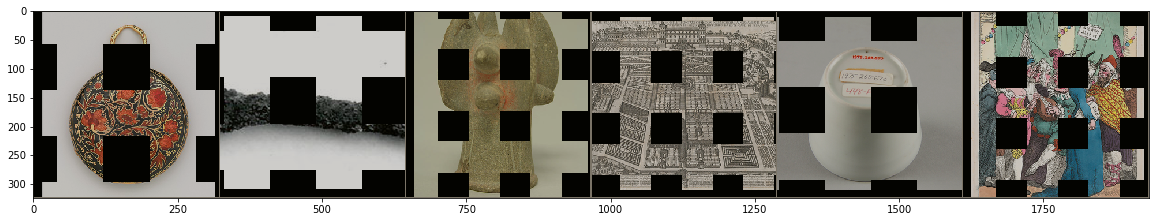

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)